In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

Reading Data

In [2]:
Combffq = pd.read_stata('../Combffq_04Apr19.dta')
Combpaq = pd.read_stata('../Combpaq_04Apr19.dta')
PEvent = pd.read_stata('../PEvent_04Apr19.dta')
nutrition_vars = pd.read_table('nutritionVariables.txt', sep=',')
physical_activities = pd.read_table('physicalActivities.txt', sep=',')

In [3]:
ffqcols = ['idno'] + list(nutrition_vars.abbreviation)
paqcols = ['idno'] + [_.lower() for _ in physical_activities.abbreviation]
merged_data = Combffq[ffqcols].merge(Combpaq[paqcols], left_on='idno', right_on='idno', how='inner')
merged_data = merged_data.merge(PEvent[['idno', 'newdiab']], left_on='idno', right_on='idno', how='inner')
# null_series = merged_data.isna().sum().sort_values(ascending=False)
# too_null_cols = null_series[(null_series>5000)]
# DF = merged_data.drop(too_null_cols.index.tolist(), axis=1)
DF = merged_data.fillna(0)

Splitting data into train and test

In [4]:
X_all_train, X_test, y_all_train, y_test = train_test_split(DF.iloc[:,1:-1], DF.iloc[:,-1], test_size=0.2)

Upsampling the train data

In [5]:
# diabetic_idx = np.ndarray.flatten(np.array(np.where(y_all_train==1)))
# upsampling_idx = np.random.choice(diabetic_idx, len(y_all_train)-2*len(diabetic_idx), replace=True)
# sampled_X = pd.concat([X_all_train, X_all_train.iloc[upsampling_idx,]])
# sampled_y = pd.concat([y_all_train, y_all_train.iloc[upsampling_idx,]])

Downsampling the train data

In [6]:
healthy_idx = np.ndarray.flatten(np.array(np.where(y_all_train==0)))
diabetic_idx = np.ndarray.flatten(np.array(np.where(y_all_train==1)))
downsample_len = int(len(diabetic_idx)/2)
downsampling_idx = np.concatenate((np.random.choice(healthy_idx, downsample_len),np.random.choice(diabetic_idx, downsample_len)), axis=None)
np.random.shuffle(downsampling_idx)
sampled_X = X_all_train.iloc[downsampling_idx,]
sampled_y = y_all_train.iloc[downsampling_idx,]

# You may verify the effect of downsampling

In [7]:
unsampled_X = X_all_train
unsampled_y = y_all_train
# sampled_X = unsampled_X
# sampled_y = unsampled_y 

Z-Normalization only based on train data

In [8]:
# ratio_cols = ['wtredr', 'psfat']
# percentage_cols = ['pertotfat', 'persatfat', 'perprotein' ,'percho' ,'permufa' ,'perpufa']
# value_cols = list(set(sampled_X.columns)-set(ratio_cols)-set(percentage_cols))
# train_mean = sampled_X[value_cols].mean()
# train_std = sampled_X[value_cols].std()
# sampled_X.loc[:,percentage_cols] = sampled_X.loc[:,percentage_cols]/100
# X_test.loc[:,percentage_cols] = X_test.loc[:,percentage_cols]/100
# sampled_X.loc[:,value_cols] = (sampled_X.loc[:,value_cols] - train_mean)/train_std
# X_test.loc[:,value_cols] = (X_test.loc[:,value_cols] - train_mean)/train_std

Min Max Scaling only based on train data

In [9]:
ratio_cols = ['wtredr', 'psfat']
percentage_cols = ['pertotfat', 'persatfat', 'perprotein' ,'percho' ,'permufa' ,'perpufa']
value_cols = list(set(sampled_X.columns)-set(ratio_cols)-set(percentage_cols))
train_max = sampled_X.loc[:,value_cols].max()
train_min = sampled_X.loc[:,value_cols].min()
sampled_X.loc[:,percentage_cols] = sampled_X.loc[:,percentage_cols]/100
X_test.loc[:,percentage_cols] = X_test.loc[:,percentage_cols]/100
sampled_X.loc[:,value_cols] = (sampled_X.loc[:,value_cols] - train_min)/(train_max-train_min)
X_test.loc[:,value_cols] = (X_test.loc[:,value_cols] - train_min)/(train_max-train_min)

C:\Users\johnp\AppData\Local\conda\conda\envs\pure_diabetes\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-9-627e78029056>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_X.loc[:,percentage_cols] = sampled_X.loc[:,percentage_cols]/100
<ipython-input-9-627e78029056>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_X.l

Splitting train into train and validation for the batches

In [10]:
X_train, X_val, y_train, y_val = train_test_split(sampled_X, sampled_y, test_size=0.2)
# it is important: we need to hold the split correct. That is, we should not do a test split from the sampled data only. 
# Saba does this correctly, these are *_val variables
# X_train, X_val, y_train, y_val = train_test_split(sampled_X, sampled_y, test_size=0.2)

In [11]:
# should do it on the correct splits! 
rfClassifier = RandomForestClassifier()
rfClassifier.fit(X_train, y_train)
rf_y_pred = rfClassifier.predict(X_test)
print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))
print(roc_auc_score(y_test, rf_y_pred))


[[18572  9501]
 [  516   560]]
              precision    recall  f1-score   support

         0.0       0.97      0.66      0.79     28073
         1.0       0.06      0.52      0.10      1076

    accuracy                           0.66     29149
   macro avg       0.51      0.59      0.44     29149
weighted avg       0.94      0.66      0.76     29149

0.5910035135428251


In [12]:
X_train, X_val, y_train, y_val = train_test_split(unsampled_X, unsampled_y, test_size=0.2)
# should do it on the correct splits! 
rfClassifier = RandomForestClassifier()
rfClassifier.fit(X_train, y_train, )
rf_y_pred = rfClassifier.predict(X_test)
print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))
print(roc_auc_score(y_test, rf_y_pred))


[[28073     0]
 [ 1076     0]]
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     28073
         1.0       0.00      0.00      0.00      1076

    accuracy                           0.96     29149
   macro avg       0.48      0.50      0.49     29149
weighted avg       0.93      0.96      0.94     29149

0.5


C:\Users\johnp\AppData\Local\conda\conda\envs\pure_diabetes\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
def build_forest(blen, bcount, X_train, y_train):
    all_idx = range(len(X_train))
    batch_idx = [np.random.choice(all_idx, blen, replace=True) for _ in range(bcount)]
    model = RandomForestClassifier(warm_start=True, n_estimators=1)
    for b in batch_idx:
        X_batch = X_train.iloc[b,]
        y_batch = y_train.iloc[b,]
        model.fit(X_batch, y_batch)
        model.n_estimators = model.n_estimators + 1
    return model

In [14]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return roc_auc_score(y_test, y_pred)

In [15]:
best_auc, best_len, best_count = [0, 2000, 500]

In [16]:
batch_lens = range(1000,2300, 300)
batch_counts = [100, 300, 500, 700]
for l in  batch_lens:
#     print("testing batches with size equal to ", l)
    for c in batch_counts:
        print("testing", str(c), "batches, each with size equal to ", str(l), ":")
        model = build_forest(l, c, X_train, y_train)
        res = evaluate(model, X_val, y_val)
        print("\t area under the curve: ", str(res))
        if res > best_auc:
            best_auc = res
            best_len = l
            best_count = c
#     print("best auc so far: ", best_auc)

testing 100 batches, each with size equal to  1000 :
	 area under the curve:  0.5
testing 300 batches, each with size equal to  1000 :
	 area under the curve:  0.5
testing 500 batches, each with size equal to  1000 :
	 area under the curve:  0.5
testing 700 batches, each with size equal to  1000 :
	 area under the curve:  0.5
testing 100 batches, each with size equal to  1300 :
	 area under the curve:  0.5
testing 300 batches, each with size equal to  1300 :
	 area under the curve:  0.5
testing 500 batches, each with size equal to  1300 :
	 area under the curve:  0.5
testing 700 batches, each with size equal to  1300 :
	 area under the curve:  0.5
testing 100 batches, each with size equal to  1600 :
	 area under the curve:  0.5
testing 300 batches, each with size equal to  1600 :
	 area under the curve:  0.5
testing 500 batches, each with size equal to  1600 :
	 area under the curve:  0.5
testing 700 batches, each with size equal to  1600 :
	 area under the curve:  0.5
testing 100 batc

In [17]:
model = build_forest(best_len, best_count, sampled_X, sampled_y)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

[[18361  9712]
 [  497   579]]
              precision    recall  f1-score   support

         0.0       0.97      0.65      0.78     28073
         1.0       0.06      0.54      0.10      1076

    accuracy                           0.65     29149
   macro avg       0.51      0.60      0.44     29149
weighted avg       0.94      0.65      0.76     29149

0.5960744504800748


In [18]:
print(best_auc, best_count, best_len)

0.5 100 1000


In [19]:
# model = build_forest(best_len, best_count, X_train, y_train)
# y_pred = model.predict(X_val)
# print(confusion_matrix(y_val, y_pred))
# print(classification_report(y_val, y_pred))
# print(roc_auc_score(y_val, y_pred))

In [20]:
# y_pred = model.predict(X_test)
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))
# print(roc_auc_score(y_test, y_pred))

Random Forest Classifier

In [21]:
rfClassifier = RandomForestClassifier()
rfClassifier.fit(sampled_X, sampled_y)
rf_y_pred = rfClassifier.predict(X_test)
print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))
print(roc_auc_score(y_test, rf_y_pred))

[[19689  8384]
 [  535   541]]
              precision    recall  f1-score   support

         0.0       0.97      0.70      0.82     28073
         1.0       0.06      0.50      0.11      1076

    accuracy                           0.69     29149
   macro avg       0.52      0.60      0.46     29149
weighted avg       0.94      0.69      0.79     29149

0.602069077870136


In [22]:
# should do it on the correct splits! 
rfClassifier = RandomForestClassifier()
rfClassifier.fit(X_train, y_train)
rf_y_pred = rfClassifier.predict(X_test)
print(confusion_matrix(y_test, rf_y_pred))
print(classification_report(y_test, rf_y_pred))
print(roc_auc_score(y_test, rf_y_pred))


[[28073     0]
 [ 1076     0]]
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     28073
         1.0       0.00      0.00      0.00      1076

    accuracy                           0.96     29149
   macro avg       0.48      0.50      0.49     29149
weighted avg       0.93      0.96      0.94     29149

0.5


C:\Users\johnp\AppData\Local\conda\conda\envs\pure_diabetes\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNN classifier

In [23]:
from sklearn.neighbors import KNeighborsClassifier
knnClassifier = KNeighborsClassifier(n_neighbors=2)
knnClassifier.fit(sampled_X, sampled_y)
knn_y_pred = knnClassifier.predict(X_test)
print(confusion_matrix(y_test, knn_y_pred))
print(classification_report(y_test, knn_y_pred))
print(roc_auc_score(y_test, knn_y_pred))

[[21317  6756]
 [  774   302]]
              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85     28073
         1.0       0.04      0.28      0.07      1076

    accuracy                           0.74     29149
   macro avg       0.50      0.52      0.46     29149
weighted avg       0.93      0.74      0.82     29149

0.520005430610608


Decision Tree Classifier

In [24]:
from sklearn.tree import DecisionTreeClassifier
dtClassifier = DecisionTreeClassifier()
dtClassifier.fit(sampled_X, sampled_y)
dt_y_pred = dtClassifier.predict(X_test)
print(confusion_matrix(y_test, dt_y_pred))
print(classification_report(y_test, dt_y_pred))
print(roc_auc_score(y_test, dt_y_pred))

[[16595 11478]
 [  535   541]]
              precision    recall  f1-score   support

         0.0       0.97      0.59      0.73     28073
         1.0       0.05      0.50      0.08      1076

    accuracy                           0.59     29149
   macro avg       0.51      0.55      0.41     29149
weighted avg       0.93      0.59      0.71     29149

0.5469627479445847


In [25]:
voting_pred = np.zeros(len(rf_y_pred))
for i in range(len(rf_y_pred)):
    if rf_y_pred[i]+knn_y_pred[i]+dt_y_pred[i] >= 2:
        voting_pred[i] = 1
print(confusion_matrix(y_test, voting_pred))
print(classification_report(y_test, voting_pred))
print(roc_auc_score(y_test, voting_pred))

[[24689  3384]
 [  894   182]]
              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92     28073
         1.0       0.05      0.17      0.08      1076

    accuracy                           0.85     29149
   macro avg       0.51      0.52      0.50     29149
weighted avg       0.93      0.85      0.89     29149

0.5243010555194854


In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

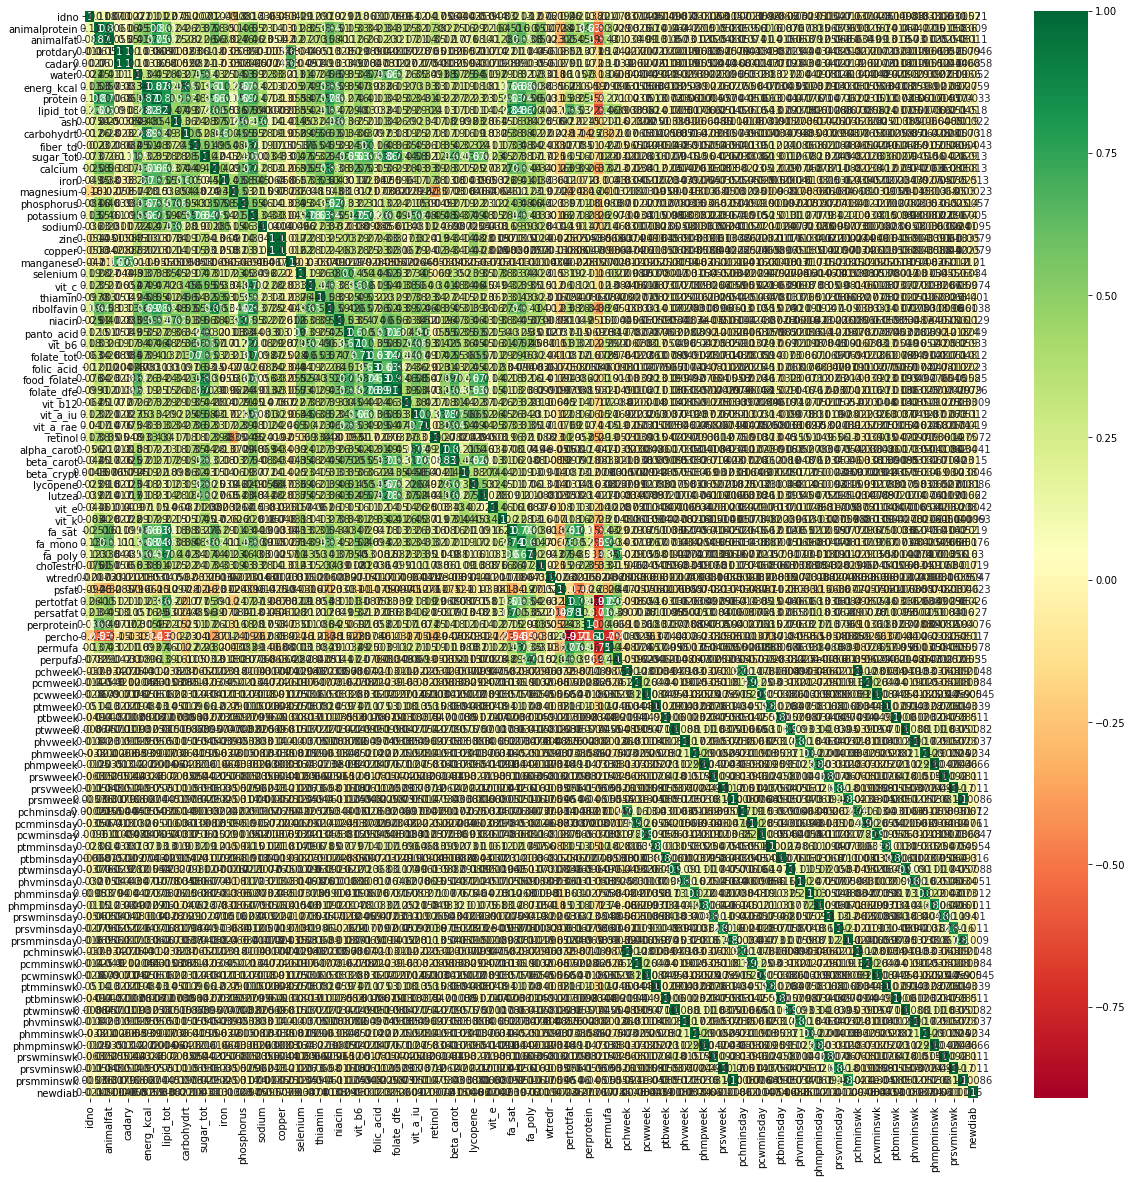

In [27]:
corrmat = DF.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(DF[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.savefig('corr.png', transparent=True)

In [28]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(model)
sel.fit(sampled_X, sampled_y)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=101, n_jobs=None,
                                                 oob_score=False,

In [29]:
sampled_X.columns[(sel.get_support())]

Index(['animalprotein', 'animalfat', 'protdary', 'cadary', 'water',
       'energ_kcal', 'protein', 'lipid_tot', 'ash', 'carbohydrt', 'fiber_td',
       'calcium', 'iron', 'magnesium', 'phosphorus', 'potassium', 'sodium',
       'zinc', 'copper', 'manganese', 'selenium', 'vit_c', 'thiamin',
       'ribolfavin', 'niacin', 'panto_acid', 'vit_b6', 'folate_tot', 'vit_b12',
       'vit_a_iu', 'vit_a_rae', 'vit_e', 'fa_sat', 'fa_mono', 'fa_poly',
       'cholestrl', 'wtredr', 'psfat', 'pertotfat', 'persatfat', 'perprotein',
       'percho', 'permufa', 'perpufa'],
      dtype='object')

In [30]:
pd.series(sel.estimator_,feature_importances_.ravel()).hist()

AttributeError: module 'pandas' has no attribute 'series'

In [ ]:
len(sel.get_support())

In [ ]:
len(ffqcols)

In [ ]:
len(paqcols)

In [ ]:
len(merged_data.columns), len(DF.columns)